# Presentation

In this notebook we have done the question answering task. First we loaded the SQuAD 1 dataset composed only of answerable questions and we set some hyper-parameters.
Then we did the preprocessing of the input and output. For the input we used the tokenizer of the model, which by providing to it the context, the question and a maximum length returns the sub-words tokenization of the input; moreover, it is possible to specify a stride to be able to extract sub-contexts from long contexts by applying a dynamic window.
For the output is necessary to determine the labels for the initial and final position of the answers in the subcontexts. So, if the answer is not inside the subcontext or fully inside the subcontext, the label is (0, 0), otherwise we have the start and end token positions as labels.
To evaluate the predictions of our model we used the metrics used in the paper and the original site of the Squad dataset and they are the exact matching and F1 Score.
Then we trained the model and finally calculated the metrics on the correct and predicted answers.
We trained and compared 5 models: bert-base-uncased, bert-base-cased, bert-large-cased, distilbert-base-cased and Roberta-base.
We can see that the best model was Roberta, Distilbert got good performance with fewer parameters, cased models get better performance than uncased models, and logically increasing the complexity increases the performance.
We can also see that increasing the complexity of the model increases the training time.
Finally we applied the same procedure for the SQuAD 2.0 dataset which contains answerable and non-answerable questions. For the unanswerable questions we set the labels to 0 for the initial and final position and the text 'Unanswerable'.
And finally we compared the same 5 previous models also on the SQuAD 2 dataset obtaining the same observations between the models.
For both datasets we have almost reached the results of the site baselines taking into account the limited number of epochs used in our case.


# Question answering


## Install and import the libraries

In [8]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 3.8 MB/s eta 0:00:00


In [9]:
import random
import json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer

In [10]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path according to your directory structure)
os.chdir('/content/drive/MyDrive/')

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive'

# Loading of the dataset SQuAD 1.0 (only answerable questions)


Load the json files

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_json = load_data('train-v2.0.json')
validation_json = load_data('dev-v2.0.json')

The structure of the training dataset is as follows:
- We have a list of main topics
- Each topic has a title and a list of paragraphs
- Each paragraph consists of a context and a list of questions and answers with the initial position of the first character of the answer in the context

The structure of the validation dataset is the same as that of the training dataset except that given a question we can have more plausible answers for that question, therefore we have a list of answers and start of positions for the first characters

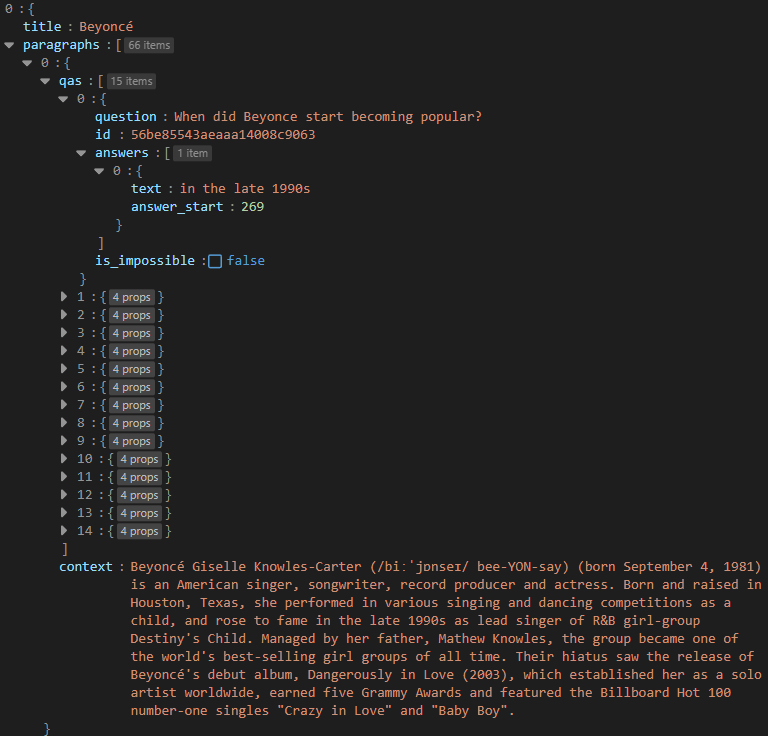


In [ ]:
print("Structure and content of the topic about Beyoncé")
train_json[0:1]

Structure and content of the topic about Beyoncé


[{'title': 'Beyoncé',
  'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?',
      'id': '56be85543aeaaa14008c9063',
      'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
      'is_impossible': False},
     {'question': 'What areas did Beyonce compete in when she was growing up?',
      'id': '56be85543aeaaa14008c9065',
      'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
      'is_impossible': False},
     {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
      'id': '56be85543aeaaa14008c9066',
      'answers': [{'text': '2003', 'answer_start': 526}],
      'is_impossible': False},
     {'question': 'In what city and state did Beyonce  grow up? ',
      'id': '56bf6b0f3aeaaa14008c9601',
      'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
      'is_impossible': False},
     {'question': 'In which decade did Beyonce become famous?',
      'id': '56bf6b0f3aeaaa14008c9602',
    

- We extract only the answerable questions from the original SQuAD 2.0 dataset in order to recreate SQuAD 1.0
- We create a list of dictionaries composed of the context, question and answer with the attached position of the first character of the answer in the context and an id

In [ ]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [qas['answers'][0]['text']], 'answer_start': [int(qas['answers'][0]['answer_start'])]},
                    })

    return dataset

train_data = extract_data_from_json(train_json)

An example of a training set data consisting of id, context, question and answer with starting position

In [ ]:
train_data[0:1]

[{'id': '56be85543aeaaa14008c9063',
  'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
  'question': 'When did Beyonce start becoming popular?',
  'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}]

In [ ]:
print("Number of answerable question in the training dataset: ", len(train_data))

Number of answerable question in the training dataset:  86821


- We extract only the answerable questions from the original SQuAD 2.0 dataset in order to recreate SQuAD 1.0
- We create a list of dictionaries composed of the context, question and possible answers with the attached position of the first character of the answers in the context and an id 

In [ ]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                  list_answers = []
                  list_answers_start = []
                  for a in qas['answers']:
                    list_answers.append(a['text'])
                    list_answers_start.append(a['answer_start'])
                  dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text': list_answers, 'answer_start': list_answers_start},
                    })
    return dataset
                  
dev_data = extract_data_from_json(validation_json)

An example of a validation set data consisting of id, context, question and answers with starting positions

In [ ]:
dev_data[0:1]

[{'id': '56ddde6b9a695914005b9628',
  'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
  'question': 'In what country is Normandy located?',
  'answers': {'text': ['France', 'France', 'France', 'France'],
   'answer_start': [159, 159, 159, 159]}}]

In [ ]:
print("Number of answerable question in the validation dataset: ", len(dev_data))

Number of answerable question in the validation dataset:  5928


- Convert the data sets into the Huggingface data set API format
- Create a container with all the splits of the data set

In [ ]:
raw_datasets = DatasetDict()
raw_datasets['train'] = Dataset.from_list(train_data)
raw_datasets['validation'] = Dataset.from_list(dev_data)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 86821
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 5928
    })
})

# Hyper-Parameters


Let's set some hyper-parameters needed for model training:
- model_name: the architecture of the model to train
- max_length: the maximum length of the input beyond which the input is truncated
- stride: the stride needed to extract by moving a dynamic window of sub-contexts from an initial context with a length greater than the limit
- num_train_epochs: the number of epochs to train the model
- learning_rate: the learning rate used to train the model
- n_best: look at the logit scores for the highest start logits and end logits
- max_answer_length: we exclude answers that are too long by defining a maximum length


Finally, we load the tokenizer of the respective model used, which is used to preprocess the data to be provided to the model for training

In [41]:
model_name = "bert-base-uncased"
#model_name = "bert-base-cased"
#model_name = "bert-large-cased"
#model_name = "distilbert-base-cased"
#model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 384
stride = 128
num_train_epochs = 3
learning_rate = 2e-5

n_best = 20
max_answer_length = 50

# Preprocessing for SQuAD 1.0

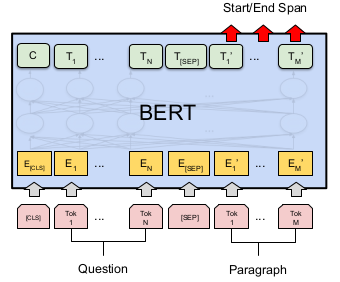

In order to train Bert on the Question Answering task it is necessary to carry out an adequate preprocessing of the training data.
The structure required for the input is as follows:
- [CLS] Question tokens [SEP] Context tokens [SEP]

[CLS] specifies that we are performing a classification task

[SEP] specifies a separator used to separate question from context

It is possible to generate this input embedding using Bert's tokenizer and supplying the context and question string as input. 

As you can see, Bert uses sub-word tokenization

In [ ]:
inputs = tokenizer(
        "What causes precipitation to fall?", #Question
        "In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity", #Context
        max_length=40,
        return_offsets_mapping=True,
        padding="max_length"
)
print("Embedding of the input composed by the question and the context")
print(inputs["input_ids"])
print("Length of embedding: ", len(inputs["input_ids"]))
print("Given the embedding of the input, we can retrieve the initial text with the special tokens")
print(tokenizer.decode(inputs["input_ids"]))
print("0 is the index for the padding token:", tokenizer.decode(0))
print("101 is the index for the classification token:", tokenizer.decode(101))
print("102 is the index for the classification token:", tokenizer.decode(102))
print("1899 is the index for the sub-word 'met' of meteorology:", tokenizer.decode(1899))
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("Sub-words tokenization:  ", [vocab_terms[vocab_index.index(i)] for i in inputs["input_ids"]])

Embedding of the input composed by the question and the context
[101, 2054, 5320, 13511, 2000, 2991, 1029, 102, 1999, 23879, 6779, 1010, 13511, 2003, 2151, 4031, 1997, 1996, 24707, 3619, 3370, 1997, 12483, 2300, 20064, 2102, 2008, 4212, 2104, 8992, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length of embedding:  40
Given the embedding of the input, we can retrieve the initial text with the special tokens
[CLS] what causes precipitation to fall? [SEP] in meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 is the index for the padding token: [PAD]
101 is the index for the classification token: [CLS]
102 is the index for the classification token: [SEP]
1899 is the index for the sub-word 'met' of meteorology: 河
Sub-words tokenization:   ['[CLS]', 'what', 'causes', 'precipitation', 'to', 'fall', '?', '[SEP]', 'in', 'meteor', '##ology', ',', 'precipitation', 'is', 'any', 'product

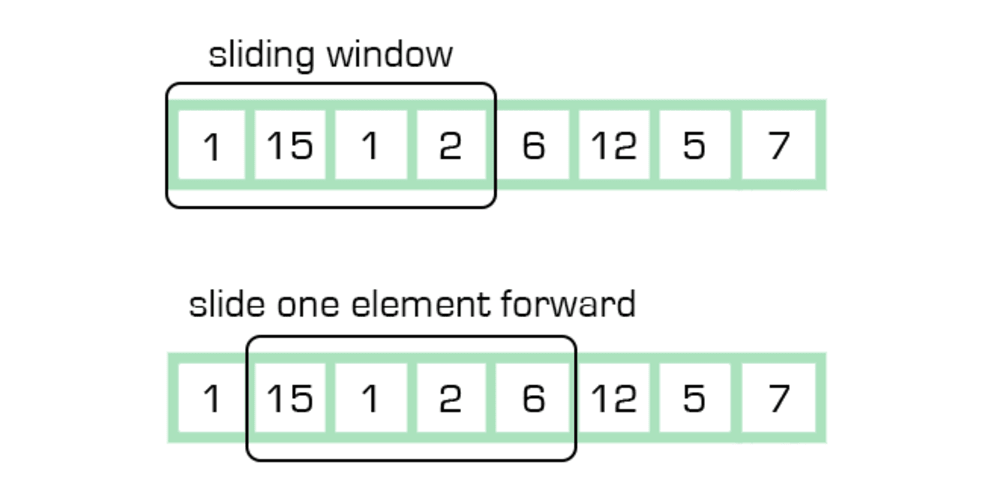

It is also possible to specify:
- max_length: the maximum length of the input beyond which the input is truncated
- truncation: if truncation is needed, you can specify whether to perform it on the question or context.
- stride: If the context and question exceeded the maximum length, it is possible to extract different sub-contexts by applying a stride with a dynamic window
- padding: If the context and the question have a length less than the maximum length, some padding is added

For example below, setting a maximum length of 25 and a stride of 10 we get 2 sub-contexts starting from the initial integer context because it exceeds the maximum length. With the truncation parameter we have specified that the truncation and the sliding window must be applied only on the context while the question is always entirely present.

In [ ]:
inputs = tokenizer(
        "What causes precipitation to fall?", #Question
        "In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity", #Context
        max_length=25,
        return_overflowing_tokens=True, # return all sub-contexts
        return_offsets_mapping=True,
        truncation="only_second",
        stride=10,
        padding="max_length"
)
print("Number of tuples of sub-context and question: ", len(inputs["input_ids"]))
print("First tuple of sub-context and question: ")
print(tokenizer.decode(inputs["input_ids"][0]))
print("Second tuple of sub-context and question: ")
print(tokenizer.decode(inputs["input_ids"][1]))

Number of tuples of sub-context and question:  2
First tuple of sub-context and question: 
[CLS] what causes precipitation to fall? [SEP] in meteorology, precipitation is any product of the condensation of atmospheric water [SEP]
Second tuple of sub-context and question: 
[CLS] what causes precipitation to fall? [SEP] any product of the condensation of atmospheric water vaport that falls under gravity [SEP]


The output also needs to be preprocessed. In particular, it is necessary to determine the labels for the initial and final position of the initial and final sub-words that make up the response in the context, in particular in the subcontexts. So:
- If the answer is not inside the context or fully inside the context, the label is (0, 0)
- Otherwise the label the start and end token positions

As we saw in the previous example, the "gravity" response is present only in the third sub-context, consequently the expected labels would be (0,0),(0,0) and (start_position,end_position) for the last sub -context containing the response.

Therefore the code below allows for each tuple of sub-context and question to understand if the answer is entirely present in the sub-context or not and to compute the start_position and end_position labels of the answer in the corresponding sub-context

In [ ]:
offset_mapping = inputs.pop("offset_mapping")
sample_map = inputs.pop("overflow_to_sample_mapping")
answer = {'text': ["gravity"], 'answer_start': [110]}
start_positions = []
end_positions = []

for i, offset in enumerate(offset_mapping):
  start_char = answer["answer_start"][0]
  end_char = answer["answer_start"][0] + len(answer["text"][0])
  sequence_ids = inputs.sequence_ids(i)

  # Find the start and end of the context
  idx = 0
  while sequence_ids[idx] != 1:
    idx += 1
    context_start = idx
  while sequence_ids[idx] == 1:
    idx += 1
    context_end = idx - 1

  # If the answer is not fully inside the context, label is (0, 0)
  if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
    start_positions.append(0)
    end_positions.append(0)
  else:
    # Otherwise it's the start and end token positions
    idx = context_start
    while idx <= context_end and offset[idx][0] <= start_char:
      idx += 1
    start_positions.append(idx - 1)

    idx = context_end
    while idx >= context_start and offset[idx][1] >= end_char:
      idx -= 1
    end_positions.append(idx + 1)

print("Start positions:", start_positions)
print("End positions:", end_positions)

Start positions: [0, 23]
End positions: [0, 23]


We have created a method that performs input and output preprocessing by computing the sub-word embedding for the input and the labels for the initial and final position of the response sub-words in the sub-context

In [ ]:
def preprocess_training(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = data["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

We compute the sub-word embedding for the input and the labels for the initial and final position of the response sub-words in the sub-context for the output for the training set

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
print("Number of tuples of context-question", len(raw_datasets["train"]))
print("Number of tuples of subcontext-question", len(train_dataset))
print("Input: ", train_dataset[0]["input_ids"])
print("Label for start position: ", train_dataset[0]["start_positions"])
print("Label for end position: ", train_dataset[0]["end_positions"])

Map:   0%|          | 0/86821 [00:00<?, ? examples/s]

Number of tuples of context-question 86821
Number of tuples of subcontext-question 87739
Input:  [101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 101

For the preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings (a mask of the same length as the input with all zeros except at the positions occupied by the subcontext where we set 1) and some way to match each created tuple (sub-context,question) to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

In [ ]:
def preprocess_validation(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(data["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

We apply the preprocessing function on the whole validation dataset like before

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
print("Number of tuples of context-question", len(raw_datasets["validation"]))
print("Number of tuples of subcontext-question", len(validation_dataset))
print("Input: ", validation_dataset[0]["input_ids"])
print("Original id for the first sub-context and question: ", validation_dataset[0]["example_id"])

Map:   0%|          | 0/5928 [00:00<?, ? examples/s]

Number of tuples of context-question 5928
Number of tuples of subcontext-question 6056
Input:  [101, 1999, 2054, 2406, 2003, 13298, 2284, 1029, 102, 1996, 5879, 2015, 1006, 5879, 1024, 2053, 3126, 2386, 5104, 1025, 2413, 1024, 5879, 5104, 1025, 3763, 1024, 5879, 3490, 1007, 2020, 1996, 2111, 2040, 1999, 1996, 6049, 1998, 6252, 4693, 2435, 2037, 2171, 2000, 13298, 1010, 1037, 2555, 1999, 2605, 1012, 2027, 2020, 9287, 2013, 15342, 1006, 1000, 5879, 1000, 3310, 2013, 1000, 15342, 2386, 1000, 1007, 10642, 1998, 8350, 2013, 5842, 1010, 10399, 1998, 5120, 2040, 1010, 2104, 2037, 3003, 4897, 2080, 1010, 3530, 2000, 8415, 10768, 2389, 3723, 2000, 2332, 2798, 3523, 1997, 2225, 23151, 7405, 1012, 2083, 8213, 1997, 27574, 1998, 6809, 2007, 1996, 3128, 26165, 1998, 3142, 1011, 26522, 4509, 7080, 1010, 2037, 8481, 2052, 6360, 13590, 2007, 1996, 8594, 2075, 2937, 1011, 2241, 8578, 1997, 2225, 23151, 7405, 1012, 1996, 5664, 3451, 1998, 5636, 4767, 1997, 1996, 5879, 2015, 6003, 3322, 1999, 1996, 2034,

# Metrics: Exact Matching & F1 Score for SQuAD 1.0


To evaluate the predictions of our model we used the metrics used in the paper and on the original site of the Squad dataset, so as to have a point of reference and make any comparisons.

The calculated metrics are: 
- exact matching: percentage of questions for which the model produces an answer identical to the reference answer provided in the SQuAD dataset. The EM is calculated as the ratio of the number of correct answers to the total number of questions
- F1 score: F1= 2*precision*recall/(precision+recall)

precision = num_same / len(pred_toks) = tp / (tp+fp)

recall = num_same / len(gold_toks) =tp / (tp+fn)

tp=num_same=number of tokens that are shared between the correct answer and the prediction

fp=len(pred_toks)-num_same=number of tokens that are in the prediction but not in the correct answer.

fn=len(correct_toks)-num_same=number of tokens that are in the correct answer but not in the prediction.

To calculate these metrics we used the evaluate library which allows us to load the metrics of the squad dataset providing the list of predicted and corrected responses as input:





In [ ]:
import evaluate
import collections

metric = evaluate.load("squad")
print("Predicted: EM")
print("Correct: exact matching")
predicted_answers = [{"id": '1', "prediction_text": "EM"}]
theoretical_answers = [{"id": '1', "answers": [{'text' : 'exact matching', 'answer_start' : 0}]}]
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))
print("Predicted: exact")
print("Correct: exact matching")
predicted_answers = [{"id": '1', "prediction_text": "exact "}]
theoretical_answers = [{"id": '1', "answers": [{'text' : 'exact matching', 'answer_start' : 0}]}]
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))
print("Predicted: exact matching")
print("Correct: exact matching")
predicted_answers = [{"id": '1', "prediction_text": "exact matching"}]
theoretical_answers = [{"id": '1', "answers": [{'text' : 'exact matching', 'answer_start' : 0}]}]
print(metric.compute(predictions=predicted_answers, references=theoretical_answers))

Predicted: EM
Correct: exact matching
{'exact_match': 0.0, 'f1': 0.0}
Predicted: exact
Correct: exact matching
{'exact_match': 0.0, 'f1': 66.66666666666666}
Predicted: exact matching
Correct: exact matching
{'exact_match': 100.0, 'f1': 100.0}


The main problem remains how to extract the predicted answer from the model since the model given the input (the sub-words embedding of the subcontext and question) returns:
- a probability distribution on the positions of the possible initial tokens from 1 to the fixed maximum length
- a probability distribution on the positions of the possible end tokens from 1 to the fixed maximum length

In reality, the probabilities are not directly supplied but the logits and we can safely pass to the probability by applying the softmax function on the distribution of the logits but it is an irrelevant operation because the result would not change.

So the model does not predict a joint distribution but 2 separate distributions assuming that the initial and final tokens are independent.

We don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest n_best logits (with n_best=20). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the rule 
log): log(ab)=log(a)+log(b)

We’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

- An answer that wouldn’t be inside the context
- An answer with negative length
- An answer that is too long (we limit the possibilities at max_answer_length)

Once we have all the scored possible answers for one example, we just pick the tuple of start and end position and so the answer with the best logit score.

Since a context can have multiple sub-contexts, we extract all responses from each sub-contexts with attached scores and then select the response with the highest score. Logically we expect that in most contexts the answer is either not present or not present at all and therefore not produce plausible answers. If no answers have been generated then we assume the question is unanswerable and return the empty string


In [ ]:
import evaluate
import collections
import numpy as np
from tqdm import tqdm

metric = evaluate.load("squad")

def compute_metrics(start_logits, end_logits, features, examples):
    # features is the validation_dataset
    example_to_features = collections.defaultdict(list)
    # we create a dictionary where the keys are the id of the original dataset that identifies a specific tuple (context, question) 
    # and the values ​​are a list of the subcontext ids of the validation_dataset that are related to these tuples
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx) # dizionario dove key=id contesto e value = id sub_context

    # examples is always the validation dataset but before preprocessing
    predicted_answers = []
    # we iterate over each tuple (context, question, answer) of the validation dataset
    for example in tqdm(examples):
        example_id = example["id"] # we extract the original id for the tuple
        context = example["context"] # we extract the context
        answers = []

        # we retrieve from the dictionary the position of each sub-context extracted from the initial tuple and loop on them
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index] # retrieve the logits distribution for the initial token location
            end_logit = end_logits[feature_index] # retrieve the logits distribution for the end token location
            offsets = features[feature_index]["offset_mapping"] # retrieves a mask identifying the subcontext tokens

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist() # we extract the indexes of the first n_best starting positions that have the highest logit
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist() # we extract the indexes of the last n_best starting positions that have the highest logit
            # we iterate for each (start_token, end_token) pair
            for start_index in start_indexes: 
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]], #extract the answer
                        "logit_score": start_logit[start_index] + end_logit[end_index], # compute the logit_score
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

# Training of the Model

We create the model first, using the AutoModelForQuestionAnswering class.

We get a warning that some weights are not used (the ones from the pretraining head) and some others are initialized randomly (the ones for the question answering head).

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

We define TrainingArguments which allows us to set some parameters for training such as:
- model_name: the name under which the model will be saved
- save_strategy: how often to save a checkpoint of the model, in our case at every epoch
- learning_rate: learning rate used for training
- num_train_epochs: number of epochs for training
- weight_decay: parameter to avoid overfitting
- fp16: it allows for reducing memory usage and accelerating training by utilizing faster computational operations

In [ ]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True
)

We just pass everything to the Trainer class using the Huggingface trainer API and launch the training. 

This is an example with the training of bert-base-uncased with 3 epochs, 2e-5 learning rate and weight_decay 0.01

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,2.715000
1000,1.678200
1500,1.504700
2000,1.386600
2500,1.324500
3000,1.317800
3500,1.264700
4000,1.246100
4500,1.174500
5000,1.193800


TrainOutput(global_step=32904, training_loss=0.8518939325475009, metrics={'train_runtime': 7783.9195, 'train_samples_per_second': 33.815, 'train_steps_per_second': 4.227, 'total_flos': 5.158331131333478e+16, 'train_loss': 0.8518939325475009, 'epoch': 3.0})

# Evaluating model on SQuAD 1.0


This is an example of evaluating the validation dataset on a trained model.

We load the last checkpoint of the model, we calculate the positions (the distributions of the logits for the start and end position) and we pass everything to the method to compute the metrics (EM and F1).

This is an example of the model trained above i.e. Bert-base-uncased for SquadD 1.0

In [ ]:
from transformers import Trainer

model = AutoModelForQuestionAnswering.from_pretrained('/content/drive/MyDrive/bert-base-uncased-without-unanswerable/checkpoint-32904')

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 5928/5928 [00:10<00:00, 566.04it/s]


{'exact_match': 79.84143049932524, 'f1': 87.90337887037848}

We import and use the pipeline method that allows us to pass it the model and to specify the task on which the model was trained and subsequently providing the context and the question automatically extracts the predicted answer.

Together with the predicted response it gives us the probability of that response and the position of the initial and final token.

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
question_answerer = pipeline("question-answering", model='/content/drive/MyDrive/bert-base-uncased-without-unanswerable/checkpoint-32904')

context = "Natural Language Processing (NLP) concerns the computational analysis, interpretation, and production of natural language in either written or spoken form. It is an interdisciplinary research field, interesting from both theoretical and practical perspectives. Decades of research have resulted in a vast collection of symbolic, stochastic, and deep-learning based models. Such models have enable the development of applications in a vast array of fields, such as human-machine interaction and chatbots, search and question answering, translation and multilingual systems, multimodal and captioning systems, speech analysis, voice interaction and personal assistants, sentiment analysis, etc, etc. This course will provide an introduction to the important problems, models and applications in NLP. The history of NLP involves many successes and many failures, demonstrating the complexity of the topic. Initially popular symbolic models turned out to be unable to capture the intrinsic complexity of natural language. Statistical techniques such as vector-space representations and linear classifiers (e.g. Support Vector Machines) enabled important applications such as web search spam detection. Word embedding techniques then became popular and improved performance on all aspects of NLP: from morphology to semantics and dialogue. More recently sequence-to-sequence modeling with deep learning techniques have greatly improved performance on hard NLP problems such machine translation and dialog generation."
question = "Who is the subject of the context?"
question_answerer(question=question, context=context)

{'score': 0.5410254001617432,
 'start': 105,
 'end': 121,
 'answer': 'natural language'}

In [ ]:
question = "Which statistical techniques are used?"
question_answerer(question=question, context=context)

{'score': 0.9456495046615601,
 'start': 1049,
 'end': 1100,
 'answer': 'vector-space representations and linear classifiers'}

In [ ]:
question = "What is NLP?"
question_answerer(question=question, context=context)

{'score': 0.8369839191436768,
 'start': 0,
 'end': 27,
 'answer': 'Natural Language Processing'}

In [ ]:
question = "What is Natural Language Processing about?"
question_answerer(question=question, context=context)

{'score': 0.2584551274776459,
 'start': 47,
 'end': 121,
 'answer': 'computational analysis, interpretation, and production of natural language'}

We can also view the complete architecture of the model with the various layers

In [ ]:
print("Architure: ")
print(model)

Architure: 
BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

We can also view the full number of model parameters

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 108893186


# Model comparisons on dataset SQuAD 1.0

We trained and compared 5 types of models for the question answering task:

- Bert-base-cased
- Bert-base-uncased
- Distilbert-base-cased: a distilled version of BERT designed to be smaller (40%) and faster (60%) to fine-tune, while retaining 97% of 
accuracy
- Bert-large-cased
- Roberta-base: Facebook’s version of BERT

The main difference between cased and uncased lies in the treatment of uppercase and lowercase letters:
- In the "cased" version of BERT, the case of letters is preserved. Words are tokenized without altering the case of letters. For example, the words "Apple" and "apple" would be treated as two distinct tokens.
- In the "uncased" version of BERT, on the other hand, all letters are converted to lowercase during tokenization. So, both "Apple" and "apple" would be treated as the same token.

Bert-base-cased, Bert-base-uncased, Bert-large-cased and Ditilbert were trained with the following dataset:
-  BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers)

Instead Roberta was trained on a dataset composed of 5 datasets:
- BookCorpus, a dataset consisting of 11,038 unpublished books;
- English Wikipedia (excluding lists, tables and headers) ;
- CC-News, a dataset containing 63 millions English news articles crawled between September 2016 and February 2019.
- OpenWebText, an opensource recreation of the WebText dataset used to train GPT-2,
- Stories a dataset containing a subset of CommonCrawl data filtered to match the story-like style of Winograd schemas.

Furthermore all models were trained and evaluated with the following parameters:
- max_length = 384
- stride = 128
- num_train_epochs = 3 (2 for Bert-large) NOTE: The few epochs is due to the limitation of Colab which ensures training to a maximum of 8 hours (but actually crashed before 6 hours)
- learning_rate = 2e-5
- n_best = 20
- max_answer_length = 50


These are some baselines on some models retrieved from the official site of the SQuAD dataset (https://rajpurkar.github.io/SQuAD-explorer/). The first column is the EM and the second column is the F1 Score.

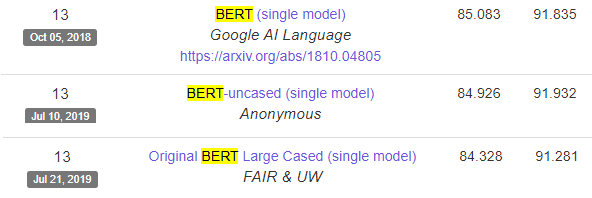

We can easily compare the performance of the F1 and EM metrics of the different models using a histogram. We can notice that:
- by increasing the complexity, ie the number of parameters, the performance improves
- distilbert which has much fewer parameters than the other models has performances that are very close to the other models
- the case-preserving bert-cased model performs better than the case-preserving bert-uncased model
- Roberta turns out to be an interesting model as it achieves the best performance with much fewer parameters than Bert-Large

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

Distilbert-base-cased  EM:  76.01  F1:  84.76
Bert-base-uncased  EM:  79.84  F1:  87.9
Bert-base-cased  EM:  80.14  F1:  88.23
Bert-large-cased  EM:  84.09  F1:  91.31
Roberta-base  EM:  85.41  F1:  91.5


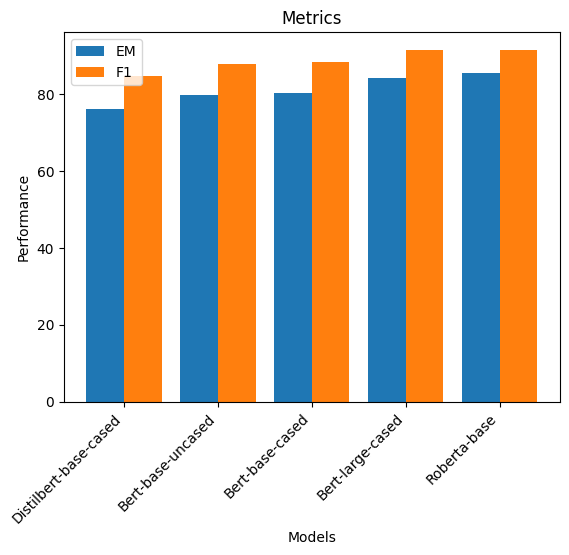

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Distilbert-base-cased', 'Bert-base-uncased', 'Bert-base-cased', 'Bert-large-cased', 'Roberta-base']
em = [76.01,79.84,80.14,84.09,85.41]
f1 = [84.76,87.90,88.23,91.31,91.50]

for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Metrics")
plt.legend()
plt.show()

We can also make a small comparison regarding the time spent training the models. It can be seen that as the complexity of the models and therefore the number of parameters increases, the training time exponentially increases.

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

Distilbert-base-cased  Training time:  45  min
Bert-base-uncased  Training time:  129  min
Bert-base-cased  Training time:  128  min
Roberta-base  Training time:  131  min
Bert-large-cased  Training time:  265  min


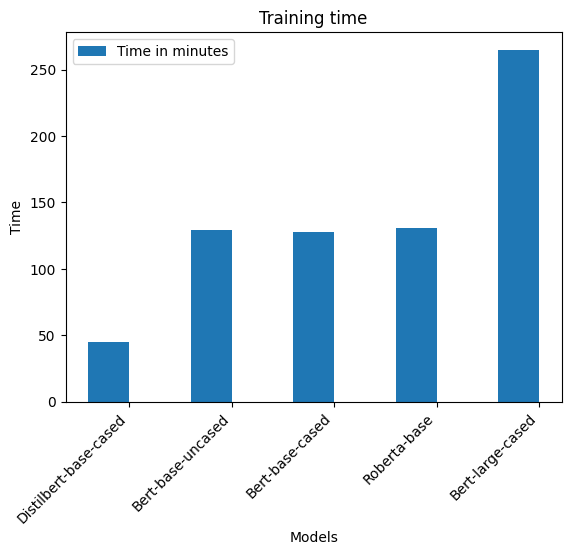

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Distilbert-base-cased','Bert-base-uncased', 'Bert-base-cased', 'Roberta-base', 'Bert-large-cased']
time = [45,129,128,131,265]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Training time")
plt.legend()
plt.show()

And finally we can compare the number of parameters for each model

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

Distilbert-base-cased  #Parameters:  65192450
Bert-base-uncased  #Parameters:  108893186
Bert-base-cased  #Parameters:  107721218
Roberta-base  #Parameters:  124056578
Bert-large-cased  #Parameters:  332531714


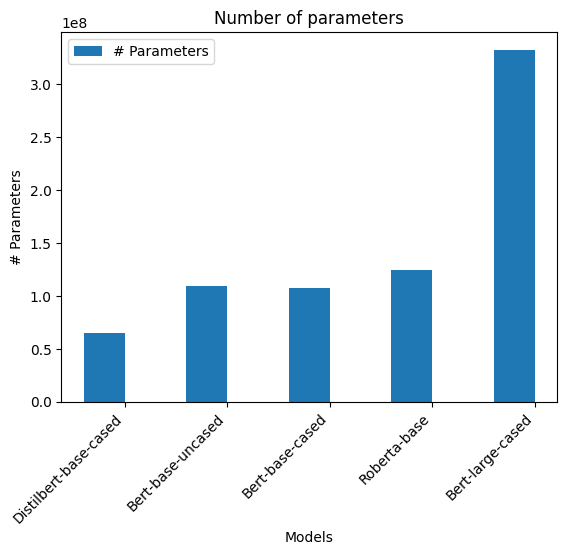

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Distilbert-base-cased','Bert-base-uncased', 'Bert-base-cased', 'Roberta-base', 'Bert-large-cased']
num_params = [65192450,108893186,107721218,124056578,332531714]
  
for i in range(len(X)):
  print(X[i], " #Parameters: ", num_params[i])

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, num_params, 0.4, label = '# Parameters')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("# Parameters")
plt.title("Number of parameters")
plt.legend()
plt.show()

# Loading of the dataset SQuAD 2.0 (answerable and unanswerable questions)


Load the json files

In [11]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_json = load_data('train-v2.0.json')
validation_json = load_data('dev-v2.0.json')

- We extract the answerable and unanswerable questions from the original SQuAD 2.0 dataset
- We create a list of dictionaries composed of the context, question and answer with the attached position of the first character of the answer in the context, an id and and a boolean flag (is_possible) to indicate whether the question is answerable or not

In [12]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [qas['answers'][0]['text']], 'answer_start': [int(qas['answers'][0]['answer_start'])]},
                                    'is_possible': True
                    })
                else:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [''], 'answer_start': [0]},
                                    'is_possible': False
                    })

    return dataset

train_data = extract_data_from_json(train_json)

An example of a training set data consisting of id, context, question and answer with starting position and answerability

Answerable question:

In [29]:
train_data[0:1]

[{'id': '56be85543aeaaa14008c9063',
  'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
  'question': 'When did Beyonce start becoming popular?',
  'answers': {'text': ['in the late 1990s'], 'answer_start': [269]},
  'is_possible': True}]

Unanswerable question:

In [28]:
train_data[2075:2076]

[{'id': '5a8d7bf7df8bba001a0f9ab1',
  'context': 'The Legend of Zelda: Twilight Princess (Japanese: ゼルダの伝説 トワイライトプリンセス, Hepburn: Zeruda no Densetsu: Towairaito Purinsesu?) is an action-adventure game developed and published by Nintendo for the GameCube and Wii home video game consoles. It is the thirteenth installment in the The Legend of Zelda series. Originally planned for release on the GameCube in November 2005, Twilight Princess was delayed by Nintendo to allow its developers to refine the game, add more content, and port it to the Wii. The Wii version was released alongside the console in North America in November 2006, and in Japan, Europe, and Australia the following month. The GameCube version was released worldwide in December 2006.[b]',
  'question': 'What category of game is Legend of Zelda: Australia Twilight?',
  'answers': {'text': [''], 'answer_start': [0]},
  'is_possible': False}]

- We extract the answerable and unanswerable questions from the original SQuAD 2.0 dataset
- We create a list of dictionaries composed of the context, question and answer with the attached position of the first character of the answer in the context, an id and and a boolean flag (is_possible) to indicate whether the question is answerable or not
- For the validation dataset, we used the 'Unanswerable' response as the default response as the method to calculate the metrics does not consider empty responses

In [31]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                  list_answers = []
                  list_answers_start = []
                  for a in qas['answers']:
                    list_answers.append(a['text'])
                    list_answers_start.append(a['answer_start'])
                  dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text': list_answers, 'answer_start': list_answers_start},
                                  'is_possible': True
                    })
                else:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : ['Unanswerable'], 'answer_start': [0]},
                                    'is_possible': False
                                    
                    })
                    
    return dataset
                  
dev_data = extract_data_from_json(validation_json)

An example of a validation set data consisting of id, context, question and answers with starting positions

Answerable:

In [32]:
dev_data[0:1]

[{'id': '56ddde6b9a695914005b9628',
  'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
  'question': 'In what country is Normandy located?',
  'answers': {'text': ['France', 'France', 'France', 'France'],
   'answer_start': [159, 159, 159, 159]},
  'is_possible': True}]

Unanswerable:

In [35]:
dev_data[5:6]

[{'id': '5ad39d53604f3c001a3fe8d1',
  'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
  'question': "Who gave their name to Normandy in the 1000's and 1100's",
  'answers': {'text': ['Unanswerable'], 'answer_start': [0]},
  'is_possible': False}]

- Convert the data sets into the Huggingface data set API format
- Create a container with all the splits of the data set

In [36]:
raw_datasets = DatasetDict()
raw_datasets['train'] = Dataset.from_list(train_data)
raw_datasets['validation'] = Dataset.from_list(dev_data)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 11873
    })
})

In [37]:
print("Training Set")
print("Total question: ", len(raw_datasets['train']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['train']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['train']["is_possible"])-sum(raw_datasets['train']["is_possible"]))

Training Set
Total question:  130319
Total answerable:  86821
Total unanswerable:  43498


In [38]:
print("Validation Set")
print("Total question: ", len(raw_datasets['validation']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['validation']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['validation']["is_possible"])-sum(raw_datasets['validation']["is_possible"]))

Validation Set
Total question:  11873
Total answerable:  5928
Total unanswerable:  5945


# Preprocessing for SQuAD 2.0

The only thing that changes from the preprocessing of SQuAD 1.0 is that for unanswerable questions we set the label 0 as start token and end token:

In [39]:
def preprocess_training(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = data["answers"]
    is_possible = data["is_possible"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if is_possible[sample_idx] == False:
          start_positions.append(0)
          end_positions.append(0)
        else:
          # If the answer is not fully inside the context, label is (0, 0)
          if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
              start_positions.append(0)
              end_positions.append(0)
          else:
              # Otherwise it's the start and end token positions
              idx = context_start
              while idx <= context_end and offset[idx][0] <= start_char:
                  idx += 1
              start_positions.append(idx - 1)

              idx = context_end
              while idx >= context_start and offset[idx][1] >= end_char:
                  idx -= 1
              end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

We compute the sub-word embedding for the input and the labels for the initial and final position of the response sub-words in the sub-context for the output for the training set

In [42]:
train_dataset = raw_datasets["train"].map(
    preprocess_training,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
print("Number of tuples of context-question", len(raw_datasets["train"]))
print("Number of tuples of subcontext-question", len(train_dataset))
print("Input: ", train_dataset[0]["input_ids"])
print("Label for start position: ", train_dataset[0]["start_positions"])
print("Label for end position: ", train_dataset[0]["end_positions"])

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Number of tuples of context-question 130319
Number of tuples of subcontext-question 131754
Input:  [101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1


The preprocessing of the validation set does not change from SQuAD 1.0

In [43]:
def preprocess_validation(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(data["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [44]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
print("Number of tuples of context-question", len(raw_datasets["validation"]))
print("Number of tuples of subcontext-question", len(validation_dataset))
print("Input: ", validation_dataset[0]["input_ids"])
print("Original id for the first sub-context and question: ", validation_dataset[0]["example_id"])

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Number of tuples of context-question 11873
Number of tuples of subcontext-question 12134
Input:  [101, 1999, 2054, 2406, 2003, 13298, 2284, 1029, 102, 1996, 5879, 2015, 1006, 5879, 1024, 2053, 3126, 2386, 5104, 1025, 2413, 1024, 5879, 5104, 1025, 3763, 1024, 5879, 3490, 1007, 2020, 1996, 2111, 2040, 1999, 1996, 6049, 1998, 6252, 4693, 2435, 2037, 2171, 2000, 13298, 1010, 1037, 2555, 1999, 2605, 1012, 2027, 2020, 9287, 2013, 15342, 1006, 1000, 5879, 1000, 3310, 2013, 1000, 15342, 2386, 1000, 1007, 10642, 1998, 8350, 2013, 5842, 1010, 10399, 1998, 5120, 2040, 1010, 2104, 2037, 3003, 4897, 2080, 1010, 3530, 2000, 8415, 10768, 2389, 3723, 2000, 2332, 2798, 3523, 1997, 2225, 23151, 7405, 1012, 2083, 8213, 1997, 27574, 1998, 6809, 2007, 1996, 3128, 26165, 1998, 3142, 1011, 26522, 4509, 7080, 1010, 2037, 8481, 2052, 6360, 13590, 2007, 1996, 8594, 2075, 2937, 1011, 2241, 8578, 1997, 2225, 23151, 7405, 1012, 1996, 5664, 3451, 1998, 5636, 4767, 1997, 1996, 5879, 2015, 6003, 3322, 1999, 1996, 203

# Metrics: Exact Matching & F1 Score for SQuAD 2.0

Also for the evaluation of the metrics almost nothing changes compared to SQuAD 1.0 except that in the case in which the label 0 is predicted for the start token and end token then we predict the response 'Unanswerable'

In [45]:
import evaluate
import collections
import numpy as np

metric = evaluate.load("squad")

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx) # dizionario dove key=id contesto e value = id sub_context

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]     
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"] 

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # returns an empty response
                    if (start_index == 0) and (end_index == 0):
                      answer = {
                        "text": 'Unanswerable',
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                      }
                      answers.append(answer)
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": "Unanswerable"})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]

    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

# Model comparisons on dataset SQuAD 2.0

We trained and compared 5 types of models for the question answering task:

- Bert-base-cased
- Bert-base-uncased
- Distilbert-base-cased: a distilled version of BERT designed to be smaller (40%) and faster (60%) to fine-tune, while retaining 97% of 
accuracy
- Bert-large-cased
- Roberta-base: Facebook’s version of BERT

The main difference between cased and uncased lies in the treatment of uppercase and lowercase letters:
- In the "cased" version of BERT, the case of letters is preserved. Words are tokenized without altering the case of letters. For example, the words "Apple" and "apple" would be treated as two distinct tokens.
- In the "uncased" version of BERT, on the other hand, all letters are converted to lowercase during tokenization. So, both "Apple" and "apple" would be treated as the same token.

Bert-base-cased, Bert-base-uncased, Bert-large-cased and Ditilbert were trained with the following dataset:
-  BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers)

Instead Roberta was trained on a dataset composed of 5 datasets:
- BookCorpus, a dataset consisting of 11,038 unpublished books;
- English Wikipedia (excluding lists, tables and headers) ;
- CC-News, a dataset containing 63 millions English news articles crawled between September 2016 and February 2019.
- OpenWebText, an opensource recreation of the WebText dataset used to train GPT-2,
- Stories a dataset containing a subset of CommonCrawl data filtered to match the story-like style of Winograd schemas.

Furthermore all models were trained and evaluated with the following parameters:
- max_length = 384
- stride = 128
- num_train_epochs = 3 (2 for Bert-large) NOTE: The few epochs is due to the limitation of Colab which ensures training to a maximum of 8 hours (but actually crashed before 6 hours)
- learning_rate = 2e-5
- n_best = 20
- max_answer_length = 50


These are some baselines on some models retrieved from the official site of the SQuAD dataset (https://rajpurkar.github.io/SQuAD-explorer/). The first column is the EM and the second column is the F1 Score.

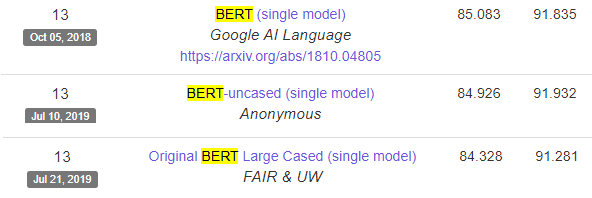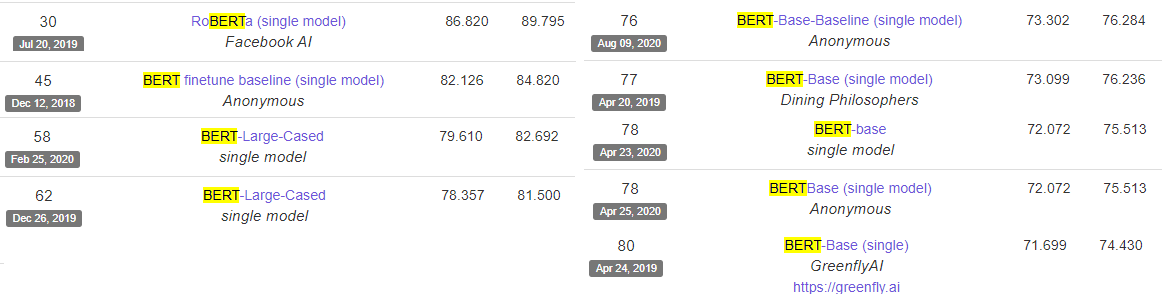

We can easily compare the performance of the F1 and EM metrics of the different models using a histogram. We can notice that:
- by increasing the complexity, ie the number of parameters, the performance improves
- distilbert which has much fewer parameters than the other models has performances that are very close to the other models
- the case-preserving bert-cased model performs better than the case-preserving bert-uncased model

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

Distilbert-base-cased  EM:  65.62  F1:  68.94
Bert-base-uncased  EM:  71.98  F1:  75.51
Bert-base-cased  EM:  72.07  F1:  75.59
Bert-large-cased  EM:  77.04  F1:  80.53
Roberta-base  EM:  79.73  F1:  82.94


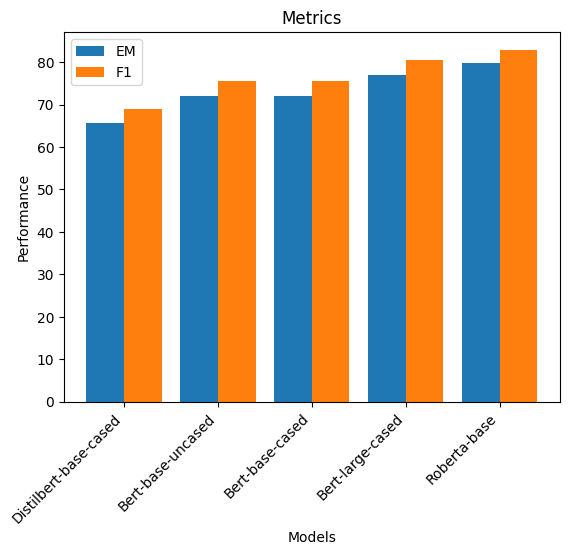

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Distilbert-base-cased', 'Bert-base-uncased', 'Bert-base-cased', 'Bert-large-cased', 'Roberta-base']
em = [65.62,71.98,72.07,77.04,79.73]
f1 = [68.94,75.51,75.59,80.53,82.94]

for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Metrics")
plt.legend()
plt.show()

We can also make a small comparison regarding the time spent training the models. It can be seen that as the complexity of the models and therefore the number of parameters increases, the training time exponentially increases.

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

Distilbert-base-cased  Training time:  100  min
Bert-base-uncased  Training time:  196  min
Bert-base-cased  Training time:  191  min
Bert-large-cased  Training time:  190  min
Roberta-base  Training time:  204  min


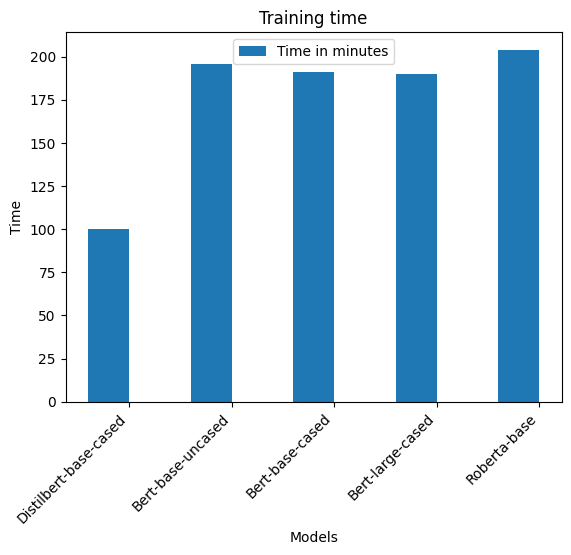

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Distilbert-base-cased','Bert-base-uncased', 'Bert-base-cased', 'Bert-large-cased', 'Roberta-base']
time = [100,196,191,190,204]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Training time")
plt.legend()
plt.show()